In [215]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers,Sequential
import numpy as np
import matplotlib.pyplot as plt

In [183]:
# 自定义参数
TRAIN_BUF = 60000
BATCH_SIZE = 128
TEST_BUF = 10000

#2.获取数据
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28).astype('float32')

# 标准化图片到区间 [0., 1.] 内
train_images /= 255.
test_images /= 255.

# 二值化，对数值像素进行伯努利分布建模
train_images[train_images >= .5] = 1.  #shape = (60000,28,28)
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

train_images = train_images.reshape((60000,784))
test_images  = test_images.reshape((10000,784))

# 添加椒盐噪音
SNR = 0.99

# 制作噪声面具，0表示原图不动
train_images_noise = train_images
test_images_noise = test_images

mask_train = np.random.choice((0,1,2),size=(60000,784),p=[SNR,(1-SNR)/2.,(1-SNR)/2.])
train_images_noise[mask_train==1]=1
train_images_noise[mask_train==2]=0

mask_test = np.random.choice((0,1,2),size=(10000,784),p=[SNR,(1-SNR)/2.,(1-SNR)/2.])
test_images_noise[mask_test==1]=1
test_images_noise[mask_test==2]=0

train_data = np.hstack((train_images,train_images_noise))
test_data = np.hstack((test_images,test_images_noise))




# 将原始数据集作为label，因此要改变形状
train_dataset = tf.data.Dataset.from_tensor_slices((train_data)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data)).shuffle(TEST_BUF).batch(BATCH_SIZE)




In [192]:
# 定义自己的模型
latent_dimension = 50

def split_image(input):
    return tf.split(input,num_or_size_splits=2,axis=-1)[1]

def sampling(agrs):
    mean,logvar = agrs[0],agrs[1]
    eps = tf.random.normal(tf.shape(mean))
    
    return mean + eps*tf.exp(logvar * 0.5)


# 编码阶段
    
x = layers.Input(shape=(784*2,)) 
x_noise = layers.Lambda(split_image,output_shape=(784,))(x)
h1 = layers.Dense(200,activation='softplus')(x_noise)
h2 = layers.Dense(200,activation='softplus')(h1)
# 均值和方差层不需要激活函数
mean = layers.Dense(latent_dimension)(h2)
log_var = layers.Dense(latent_dimension)(h2)
    
# 将采样过程看成一个Lambda层
z = layers.Lambda(sampling,output_shape=(latent_dimension,))([mean,log_var])
    
# 解码阶段
h3 = layers.Dense(200,activation='softplus')
h4 = layers.Dense(200,activation='softplus')
h5 = layers.Dense(200,activation='softplus')
# No activation
end = layers.Dense(784)
z1 = h3(z)
z2 = h4(z1)
z3 = h5(z2)
out = end(z3)

    
# 建立模型
model = tf.keras.Model(x,out)
    
cross_ent = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.split(x,num_or_size_splits=2,axis=-1)[0],logits=out),axis=-1) # 重构误差
KL = -tf.reduce_sum(1+log_var-tf.square(mean)-tf.exp(log_var),axis=-1)
dvae_loss = tf.reduce_mean(cross_ent + KL)
model.add_loss(dvae_loss)

# 编译
model.compile(optimizer='adam')
# fit
history = model.fit(train_dataset,epochs=80,validation_data=test_dataset)    

Train for 469 steps, validate for 79 steps
Epoch 1/80
469/469 [==============================] - 6s 12ms/step - loss: 216.1292 - val_loss: 202.0118
Epoch 2/80
469/469 [==============================] - 5s 10ms/step - loss: 187.5701 - val_loss: 176.2872
Epoch 3/80
469/469 [==============================] - 5s 10ms/step - loss: 169.0299 - val_loss: 162.8189
Epoch 4/80
469/469 [==============================] - 5s 11ms/step - loss: 159.3387 - val_loss: 154.1776
Epoch 5/80
469/469 [==============================] - 5s 11ms/step - loss: 151.8879 - val_loss: 149.4474s - loss: 151.
Epoch 6/80
469/469 [==============================] - 5s 11ms/step - loss: 147.6719 - val_loss: 145.7656
Epoch 7/80
469/469 [==============================] - 5s 10ms/step - loss: 144.4170 - val_loss: 142.7016
Epoch 8/80
469/469 [==============================] - 4s 9ms/step - loss: 142.3120 - val_loss: 141.5059
Epoch 9/80
469/469 [==============================] - 5s 10ms/step - loss: 140.7709 - val_loss: 139.8104

469/469 [==============================] - 5s 10ms/step - loss: 123.5979 - val_loss: 128.4429
Epoch 77/80
469/469 [==============================] - 5s 10ms/step - loss: 123.4854 - val_loss: 128.4444
Epoch 78/80
469/469 [==============================] - 5s 10ms/step - loss: 123.4413 - val_loss: 128.3501
Epoch 79/80
469/469 [==============================] - 5s 10ms/step - loss: 123.3777 - val_loss: 128.2272
Epoch 80/80
469/469 [==============================] - 5s 10ms/step - loss: 123.2653 - val_loss: 128.4152


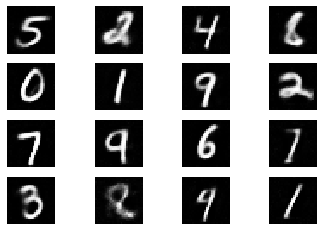

In [220]:
# 保存模型
model.save_weights('./selfdvae')

# 构造生成器

decoder_input = layers.Input(shape=(latent_dimension,))
h1_decoder = h3(decoder_input) #200
h2_decoder = h4(h1_decoder)    #200
h3_decoder = h5(h2_decoder)    #200
decoder_output = end(h3_decoder) 

generator = tf.keras.Model(decoder_input,decoder_output)

# 从N(0,1)中采样16个图片
gussian_noise = tf.random.normal(shape=(16,latent_dimension))

# 预测
pred_from_sampling = generator.predict(gussian_noise)
pred_from_sampling = pred_from_sampling.reshape(16,28,28)
pred_from_sampling = tf.sigmoid(pred_from_sampling)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(pred_from_sampling[i,:,:],cmap='gray')
    plt.axis('off')

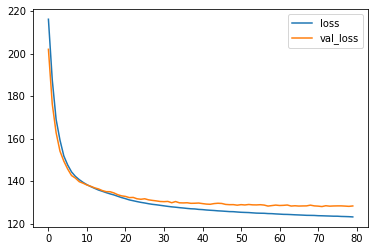

In [222]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.show()

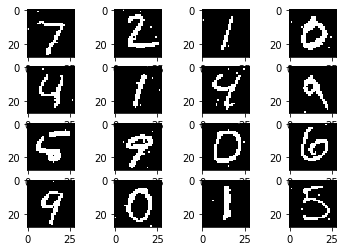

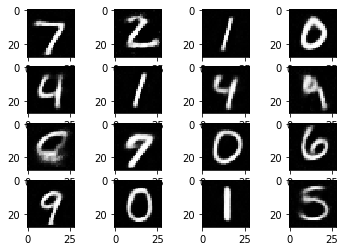

In [213]:
# 先把原始图片打印出来
plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(test_images[i,:].reshape(28,28),cmap='gray')
    
# 再把预测的图像打印出来
plt.figure()

pred = model.predict(test_data[0:16,:])
pred = tf.reshape(pred,(16,28,28))
pred = tf.sigmoid(pred)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(pred[i,:,:],cmap='gray')